<a href="https://colab.research.google.com/github/Raahim58/Neural-networks/blob/main/05_makemore_part4_backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05. Building Makemore from scratch (Part4: Becoming a backprop ninja)

* Makemore makes more of the things you give it.
* makemore takes one text file as input, where each line is assumed to be one training thing, and generates more things like it. Under the hood, it is an autoregressive character-level language model, with a wide choice of models from bigrams all the way to a Transformer (exactly as seen in GPT). For example, we can feed it a database of names, and makemore will generate cool baby name ideas that all sound name-like, but are not already existing names. Or if we feed it a database of company names then we can generate new ideas for a name of a company. Or we can just feed it valid scrabble words and generate english-like babble.
* it is basically a bigram character-level language model

**Resources:**

* makemore github repo: https://github.com/karpathy/makemore/tree/master

* tutorial lecture 5 (makemore part 4) code: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part4_backprop.ipynb

* MLP model based on 2003 paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

* makemore pre defined code: https://github.com/karpathy/makemore/blob/master/makemore.py

* link to youtube lecture 4: https://www.youtube.com/watch?v=q8SA3rM6ckI&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=5

* whole lecture series code: https://github.com/karpathy/nn-zero-to-hero



## 0. Getting data + intro

* we are going to be doing backpropogation manuall instead of using `loss.backward()`. It is a very important exercises because:
  * it is a leaky abstraction: backprop doesn't make your network magically so you need to understand it under the hood if you need to debug it and make it run in your neural net
  * it will make everything explicit so you know what's going on
* we've covered autograd and we wrote micrograd. Micrograd was an autograd engine only on the level of individual scalars so the atoms were individual single numbers
* running backprop manually right now is not recommended because it's very time consuming as compared to `loss.backward()`
* we'll lose the `loss.backward()` and do the backprop manually



In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
!wget https://github.com/karpathy/makemore/raw/master/names.txt

--2024-08-28 06:23:11--  https://github.com/karpathy/makemore/raw/master/names.txt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/karpathy/makemore/master/names.txt [following]
--2024-08-28 06:23:11--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-08-28 06:23:12 (6.26 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item() # value exactly equal?
  app = torch.allclose(dt, t.grad) # value approximately equal due to fpn arithmetic?
  maxdiff = (dt - t.grad).abs().max().item() # abs max value difference
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

* we're going to have gradients that we estimate manually ourselves, and we're going to have gradients that PyTorch calculates
* we're going to be checking for correctness assuming that PyTorch is correct

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


* the initialization has been changed a little bit to be small numbers. So normally we would set the biases to be 0, here we are setting them to small random numbers. We do this because if our variables are initialized exactly 0, sometimes it can mask an incorrect implementation of a gradient because when everything is 0, it simplifies and sort of gives a simpler expression of the gradient
* we use b1 anyways despite of having a batchNorm layer later which will just cancel out the bias because we'll have a gradient w.r.t it and we can check if we're still calculating it correctly

In [8]:
# calculating a single batch
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [9]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3401, grad_fn=<NegBackward0>)

* forward pass is quite expanded from the previous lecture because:
  1. normally we used `cross_entropy` but over here we usr an explicit manual implementation of the loss function
  2. we broke the implementation in small chunks so we have a lot of intermediary tensors along the way, and this is because we're about to go backwards and calculate the gradient in this backprop from the bottom too the top
    * in forward pass we have log probs tensor, but in backward pass we'll have a delog probs which will store the derivative of the loss function w.r.t the loss log function
* we tell PyTorch that we retain the grad's of every value because in exercise 1 we're going to calculate the backward pass -> we'll calculate all these `de` variables and then use the cmp function to check our correctness according to what PyTorch is telling us
* in exercise 2 we break up the loss and backpropogate through it manually in all the atomic pieces that make it up but here we will collapse the loss in a single `cross_entropy` call and instead we're going to analytically derive using mth and paper and pencil, the gradient of the loss w.r.t logits. Instead of backproping through all of its little chunks one at a time, we will just going to analytically derive what that gradient is and we're going to implement that
* we'll do the same with batch normalization. instead of breaking batchNorm in little pieces, we're going to use maths to derive the gradient through the batchNorm layer -> much more efficient instead of backpropogating through its layers independently: exercise 3

## 1. Exercise 1: backpropogating through the atomic compute graph



### 1.1 Backpropogating through `loss`

In [10]:
logprobs.shape

torch.Size([32, 27])

* `dlogprobs`: we need to understand what will go here to calculate the gradient of the loss w.r.t all the elements of the logprobs tensor
  * will hold the derivative of the loss w.r.t all the elements of `logprobs` -> `dlogprobs` will be the same shape/size as `logprobs`
  * how does it influence loss?
    * loss is negative `logprobs` indexed with a range of n and Yb with the mean of that (Yb is an array of all the correct indices of the next character in the sequence)
    ```
    loss = -logprobs[range(n), Yb].mean()
    ```
    * once we've plucked out the examples, we're taking the mean and then the negative so essentially (n = size of the batch):
    ```
    loss = -(a + b + c) / 3
    dloss/da = 1/3 -> -1/n
    ```
    * only 32 probabilites from `logprobs` participate in the loss calculation so what's the derivative of all the other most elements that do not get plucked out, well their gradient is intuitivel is 0 since they don't participate in the loss so most of these numbers inside this tensor does not feed into the loss so if we were to change these numbers, the loss doesn't change which is the equivalent way of saying that the derivative of the loss w.r.t them is 0 (they don't impact it)



* `logprobs` depends on log:
```
logprobs = probs.log()
```
  * all elements of probs are element wise being applied log to
  * in micrograd there is a `log` node which takes in `probs` and creates `logprobs`; `dprobs` will be the local derivative of that individual operation `log` * derivative loss w.r.t its output (in this case `dlogprobs`)
    * local derivative of this operation (taking `log` element wise) -> d/dx (logx) = x -> 1/probs
    * then use chain rule to get dprobs and compare the values
    * probs is going to be inverted and then element wise be applied to dlogprobs so if `probs` is very close to 1 means your network is predicting the character quickly and `dprobs` will be 1/1 with `dlogprobs` just passing through. If probs is incorrectly assigned (low probs) then dprobs will be huge
    * basically what is happening is intuitively it is taking the examples that have a very low probability assigned and is boosting their gradient



* `dcounts_sum_inv`: first you take the `logits` coming out of the neural net and then find the max in each row, and then subtract it for the purposes of numerical stability
  * if you don't do this you run into numerical issues if some of the logits take on too large values if we end up exponentiating them -> essentially for safety
  * `counts` are then created by exponentiating the `logits` and then we take the sum of these counts and normalize so the probs sum to 1 -> then invert them to get `counts_sum_inv`
  * in this multiplication:
  ```
  probs = counts * counts_sim_inv
  ```
  here we have an implicit broadcasting that PyTorch will do because it needs to take this column tensor of 32 numbers and replicate it horizontally 27 times to align these 2 tensors and do an element wise multiply, using a toy example:
  ```
  c = a * b # but with tensors:
  a[3x3] * b[3,1]
  a11*b1 a12*b1 a13*b1
  a21*b2 a22*b2 a23*b2
  a31*b3 a32*b3 a33*b3
  c[3x3]
  ```
    * this looks like a single operation but it is actually 2 operations applied sequentially:
      1. replication: it took the column tensor and replicated across all the  columns (27 times)
      2. multiplication: let's backprob through the element wise multiplication: local derivative (counts) * dprobs (due to the chain rules)
        * this is the derivative or gradient w.r.t replicated `b`. We don't have a replicated `b` we just have a single `b` column, how do we back propogate through the replication? -> `b1` is similar to `b2` and `b3` but is just being used multiple times
        * to backprop through the replication, we need to summ all the gradients that arrive at any one node (if a node is used multiple times, the gradient for all of its uses sum during back prop). Since `b1` is used multiple times, the right thing to do is to sum horizontally across all the rows with dim=1 but we want to retain dimension so that the `counts` and the its gradient are going to exactly be the same shape so we keep `keepdim=True` so that we don't lose this dimension and this will make `dcounts_sum_inv.shape` be exactly [32, 1] -> then compare it



In [11]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

* `dcounts` utilizes `counts_sum_inv` which utilizes `counts` so `counts` will actually be used twice to backpropogate (will be done ahead for the 2nd time)

* `dcounts_sum` will be found by the local derivative of `counts_sum` * chain rule (`dcounts_sum_inv`)



* backpropogating through `counts_sum` which is counts.sum along the rows, we have to make sure the `count.shape` = [32, 27] and `counts_sum.shape` = [32, 1], so in backprop we need to take the column of derivatives and transform it into a array of 2D derivative
  * basically we take some kind of input like a 3x3 matrix `a` and we sum up the rows into a column tensor `b1` -> we've got the derivative w.r.t to all `b's` now we want the local derivative w.r.t to `a's` -> how do `a's` depend on `b's` so what is the local derivative of this operation:
  ```
  a11 a12 a13 ---> b1 ( = a11 + a12 + a13)
  a21 a22 a23 ---> b2 ( = a21 + a22 + a23)
  a31 a32 a33 ---> b3 ( = a31 + a32 + a33)
  ```
    * `b1` here depends on the elements in the first row, hence derivative w.r.t them is 1, and it's derivative w.r.t to all the elements in the rows down below is 0
    * local derivative is just 1 so we land with the derivative of `b1` only, we can look at it as an addition which is a router of a gradient -> whatever gradient comes from above, it just gets routed equally to all the elements that participate in the addition so in this case the derivative of `b1` will flow equally to the derivative of `a11` `a12` `a13` horizontally
    * what we want to do is take `dcounts_sum` with size [32, 1] and we just want to replicate it 27 times horizontally to create a [32, 27] array -> so this way we're letting the broadcasting implement the replication
    * we calculate `dcounts` twice so we need to add the 2 results of the 2 branches



* `dnorm_logits`: `counts` is an element wise operation so everything is very simple with `norm_logits.exp()` with its local derivative being the same and the chain rule being `dcounts`

* we are backproping through this line:
```
norm_logits = logits -  logit_maxes
```
  * we've got `dnorm_logits` and we need `dlogits` and `dlogit_maxes`
  * we need to be careful here because the shapes here are not the same so there's an implicit broadcasting happening.
  * we have this happening:
  ```
  c32 = a32 - b3
  ```
    * for every element c we have to look at how it came to be -> every element `c` is that element of `a` minus that associated value of `b`
    * the derivatives for the `c`'s will flow equally to the corresponding `a`'s and also to the corresponding `b`'s, and in addtional the `b`'s are broadcast so we'll have to do an additional sum just like we did before
    * `dlogits` will exactly copy the derivative on `norm_logits`
    * `logit_maxes` is a column -> as we saw before because we keep replicating the same elements across all the columns, then in the backward pass because we keep reusing this, these are all just like seperate branches of use of that one variable and therefore we have to do a sum along `dim=1` with `keepdims=True` so that we don't destroy the dimension, and `logit_maxes` will be the same shape
    * we have to be careful because this `dlogits` is not the final `dlogits` and that's because not only do we get gradient signal into logits through `norm_logits`, but `logit_maxes` as a function of `logits` as well, and that's a second branch into `logits` so not our final derivative (will come back to it later for the second branch)



* we're doing this for the numerical stability of the `softmax` we're implementing. If we take one row of these logits and add or subtract any value equally to all the elements then the value of the `probs` will be unchanged. The `norm_logits = logits - logit_maxes` make sure that `norm_logits.exp()` doesn't overflow, and the reason we're using `logit_maxes` is then we're guaranteed that each row of logits, the highest number, is 0, hence this will be safe.
  * that has repercussions. If it is the case that changing `logit_maxes` does not change the `probs` and therefore does not change the loss, then the gradient on the `logit_maxes` should be 0. Due to floating point, we get very small numbers for most but not exactly 0. So, this is telling us that the values of `logit_maxes` are not impacting the final loss as they should.
  * If you don't back propogate piece by piece, you skip the branch and assume its gradient is 0



* we just backproped through `logit_maxes` and now let's do so through `logits` from the `logit_maxes = logits.max(1, keepdimg=True).values` through the second branch.
  * the max returns both the value, and it returns the indices at which those values occur to count the max value
  * in the forward pass we only used the values but in the backward pass it's extremely useful to know where those maximum values occured and thus we have the indices
  *  we have the logits tensor which is [32, 27] and in each row we find a max value, and that value gets plucked out into `logit_maxes` so intuitively the derivative flowing through here then should be: **1 * (local derivative of the appropiate entry that was plucked out) * (global derivative of `logit_maxes`)** -> so really what we're doing here is we're taking the `dlogit_maxes` and we need to scatter it to the correct positions in these `logits` from where the max values came
  * we could do it kind of similar to what we did with `logprobs` where we created a zeros and then we populated the correct elements using the correct indices and then set them to 1.
  * We could also do it using one-hot. So `f.one_hot` and then we take the `logits` of max over the first dimension (`.indices`). So i'm telling pytorch that the dimension of each of these tensors should be 27. What this will do is create an array of where the maxes came from in each row and that element is 1, and the rest of the elements are zero. So it's a one-hot vector in each row and these indices are now populating a single one in the proper place.
    * we then multiply with `dlogit_maxes` which is a columnn of [32, 1]. Hence `dlogit_maxes` will broadcast and that column will get replicated and in an element wise multiply will ensure that each of these just gets routed to whicever one of these bits is turned on
    * we use addition since this is the second branch of `dlogits`



In [12]:
Yb, logprobs[range(n), Yb]

(tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
         26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18]),
 tensor([-4.0244, -2.9800, -3.6180, -3.3766, -4.0983, -3.5030, -3.1907, -4.1117,
         -3.2165, -4.1739, -3.1300, -1.5701, -2.8552, -2.9549, -2.9740, -3.1963,
         -3.9360, -3.1111, -3.5279, -3.3466, -2.8598, -2.9436, -4.3067, -3.9901,
         -3.5353, -2.8794, -2.9267, -3.8067, -2.7514, -3.5290, -3.3112, -3.1495],
        grad_fn=<IndexBackward0>))

### 1.2 Backpropogating through linear layer 2

In [13]:
norm_logits.shape, logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

* **backward pass for linear layer:**
we'll continue with `logits` which is an outcome of a matrix multiplication and a bias offset in this linear layer:
```
logits = h @ W2 + b2 # output layer
```
  * we have a 64D hidden states. Then the W matrix projects those 64D vectors into 27D and then there's a 27 dimensional offset which is a 1D vector.
  * the plus actually broadcasts because `h` * `W2` will give us a [32, 27] so the `+b2` is a 27D vector. In the rules of broadcasting, what will happen to bias vector is that this 1D vector of 27 will get aligned with a padded dimension of one on the left and it will basically become a row vector and then it will get replicated vertically 32 times to make it [32, 27] and then there's an element-wise multiply
  * pick a small example and evaluate it to understand the pattern and then generalize and write out the general formula for how these derivatives flow in an expression like :
  ```
  d = a @ b + c
  d11 = a11b11 + a12b21 + c1
  d12 = a11b12 + a12b22 + c2
  d21 = a21b11 + a22b21 + c1
  d22 = a21b12 + a22b22 + c2
  ```
    * we have the derivative of the loss w.r.t to `d` and we'd like to know the derivative of the loss w.r.t `a` `b` and `c`
    * bias vector becomes a row vector in the broadcasting, and will replicate vertically **(look at vectors pic or at 47:12)**. Turns out all of the formulas we derived here by taking gradients can actually be expressed as a matrix multiplication -> the `b` matrix has transposed. Long story short, `dL/da is simply equal to dL/dt @ b^T(transpose)`
    * w.r.t `b`: dL/db is also a matrix multiplicatin and in this case you have to take the matrix `a` and transpose it and matrix multiply it by dL/dd giving as `dL/db`
    * w.r.t `c`: dL/Dc since you're just offsetting these expressions, you just have to take the dL/dd matrix of the derivatives of `d` and you just have to sum across the columns
    * overall, backward pass of a matrix multiply is matrix multiply. Instead of just like we had `d = a @ b + c` in the scalar case, we arrived at something very similar using matrix mul. instead of a scalar mul.
    ```python
    dL/da = dL/dd @ b^T
    dL/db = dL/dd @ a^T
    dL/dc = dL/dd @ sum(0)
    ```
  * so when we're creating `dh` we know it needs to have the same shape as `h`. `dh` should be some kind of matrix multiplication of the `logits` with `W2` and `dlogits` is [32, 27] and `W2` is [64, 27]. There is only a single way to make the shape workout and that is through `dlogits @ W2.T` -> transpose `W2` to make the shapes workout
  * `dW2` is a matrix mul. of `dlogits` and `h` and there is one transpose there too. `W2.shape` is [64, 27] so i need to transpose `h` (becomes [64, 27]) to matrix multiply it with [32, 27] giving us a [64, 27] so we multply it with `dlogits` as that's the only method.
  * `db2` is a vertical sum along the 0th axis because `b2.shape` is 27 so in order to get `dlogits` which here is [32, 27] so knowing its `dlogits` over `sum` in some direction, that direction must be 0 since we need to eliminate the dimension.

    <img src="https://raw.githubusercontent.com/Raahim58/Neural-networks/main/images/vectors.png" height=300 width=400 alt="vector 2"/>

    <img src="https://raw.githubusercontent.com/Raahim58/Neural-networks/main/images/vectors2.png" height=300 width=400 alt="vector 2"/>





### 1.3 Backpropogating through non-linear layer

* we have the derivative for `h` as `dh` already so we need to backprop through `tanh` into `hpreact`:
```python
h = torch.tanh(hpreact) # hidden layer
```
  * so we want to derive `dhpreact` and here we have to backprop through `tanh` which we already did in micrograd
    * if we have `a = tanh(z)` then `da/dz = 1 - a^2` as the local derivative, where `a` is the output of the `tanh` not the input of the `tanh`. For us `a` is `h`, with the chain rule being `dh`.

### 1.4 Backpropogating through BatchNorm layer

* we have `dhpreact` and need `dbngain` `dbnraw` and `dbnbias`:
```python
hpreact = bngain * bnraw + bnbias # * different from matrix multiply @
```
  * @ is a dot products between rows and columns for these matrices involved meanwhile * is an element wise multiply so things are simpler
  * we do have to be careful with the broadcasting happening here. `bngain` and `bnbias` are [1, 64] but `hpreact` and `bnraw` are [32, 64] so we have to makre sure that all the shapes work out fine
  * `dnbngain`, whenever we have `a*b + c`, we saw the local derivative here is just the other element with chain rule as `dhpreact`. We have to be careful because `bngain` is [1, 64] meanwhile `dhbngain` is [32, 64] and so the correct thing to do is sum as `bngain` is being replicated, and therefore all the gradients in all of the rows that are now flowing backwards need to sum up to that same tensor `dbngain`. We keep the dimensions true so we that the tensor shapes work.
  * `dbnraw` will just be the other element which is `bngain` * `dhpreact` (chain rule). For the right dimensions we need `dhpreact` as [32, 64], `bngain` is [1, 64] so it will just get replicated to create this multiplication (gets replicated same way in forward pass)
  * `dbnbias` is very similar to the bias we saw in the linear layer as `b2`. The gradients from `hpreact` will just flow into the biases and add up as these are just offsets. The 0th dimension is the examples so we sum along that dimension the same way the bias gets replicated vertically giving us [1, 64].
  


batchNorm layer:
* `bngain` and `bnbias` are the parameters so the backprop ends but `bnraw` is the output of the standardisation so here we break the batchNorm layer so that we can backprop through each line individually. What's happening is that:
  * `bnmeani` is the sum,
  * `bndiff = x - mean`,
  * `bndiff2 = x - mean^2`, `bnvar` is the variance so sigma^2 which is basically the sum of squares so `bndiff2.sum(0)` -> we normalize by 1/n-1 instead of 1/n (explained later as bessel's correction).
  * `bnvar_inv` then becomes `bnvar + 1e-5 (epsilon)` with being 1/sqrt(expression)
  * `bnraw` which is the xhat here is equal to the `bndiff` (the numerator) * `bnvar_inv`
    * for `dbnraw` we need to backprop through its line. Through writing out the shapes we get to know that `bnvar_inv` is a shape [1. 64] so there is a broadcasting happening here which we need to be careful with. It's just an element wise mul. so do the same (choose the other element `bnvarinv` as the local derivative and then use chain rule to get the output `bnraw` here).
    * Same for `dbnvar_inv`. It will take [32, 64] and multiplying it by [32, 64] but `bnvar_inv` is [1, 64] hence for `dbnvar_inv` we need a sum across the dimension 0 with `keepdims=True`. `bndiff` has 2 branches so we'll do its second branch as we go on forward

* backproping through:
```python
bnvar_inv = (bnvar + 1e-5)**-0.5 # 1e-5 = epsilon
```
  * we use the power rule where now `dbnvar = -0.5 * x(which is = bnvar+ 1e-5)**-1.5`. We also need to do a chain rule because we need to take further the derivative of `bnvar` w.r.t expression as `x`, but since this is an element wise operation and everything is fairly simple, that's just 1. The expression uptil now is the localderivative so we multiply it by the global derivative which is `dbnvar_inv`.

**Bissel's correction in `bnvar`**

* there are two ways of estimating variance of an array, one is the biased estimate which is 1/n and the other one is an unbiased estimate which is 1/(n-1) -> not mentioned clearly in the paper
  * the paper uses the biased estimated (1/n) at training time but when they do inference they used unbiased estimate (1/(n-1)). Basically they introduce a train test match where in training they use the biased version and in test time they use the unbiased version
  * unbiased estimate or 1/(n-1) gives a better estimate of the variance in case where one has samples for the population that are very small and that is the case for us since we're dealing with mini batches, and these mini batches are a small samples of a larger population which is the entire training set. So it turns out that if one just estimate using 1/n, it almost always underestimates the variance
  * we should not really have train test discrepancies. PyTorch does take in an argument through batchNorkm to ask whether one wants to use the unbiased version or the biased in both train and test. This discrepancy can often decrease when the batch sizes go larger but still better to stay away from this "bug".

backproping through `bnvar`:
* First we scrutinize the shapes with `bnvar.shape` as [1, 64] and `bndiff2.shape` as [32, 64]. We do the sum over the 0th axis to squash the first dimension. This statement of a sum across the 0th dimension from the forward pass indicates that there will be some sort of replication or broadcasting in the backward pass along the same dimension. On the other hand, a broadcasting or replication in the forward pass indicates a variable reuse in the backward pass turning into a sum over the exact same dimension.
* so we have replication in the backward pass. So we have a 2D array at the end of `bndiff2` which we are scaling by a constant (1/n-1) and then we sum over the columns vertically and scale to get a row vector `b1` and `b2`:

```python
a11 a12
a21 a22
--->
b1 b2 where:
b1 = 1/(n-1)*(a11 + a21)
b2 = 1/(n-1)*(a12 + a22)
```
  * basically the derivative of `b1` has to flow through the columns of `a` scaled by 1/(n-1)
  * intuitively the derivative flow tells us that `dbndiff2` will be the local derivative of this operation:
    * create a large array of 2D one's
    * scale it by 1.0/(n-1) -> sort of the local derivative: [32, 64]
    * for the chain rule we will just multiply by `dbnvar` -> [1, 64]
    * we let the broadcasting do the replication because in pytorch `dbnvar` will in this multiplication get copied vertically until the two are of the same shape and then there will be an element wise multiply

differentiating `bndiff2` to get `dbndiff`:
  * simple operation since to get `bndiff2`, `bndiff` is just being square which is an element wise operation in a scalar case
  * hence squared differentation is just 2x so it becomes `2*bndiff * dbndiff2 (chain rule)`
  * we already called `dbndiff` once so we need to add it now to the previous branch


backprogating through `bndiff` to get `dhprebn` and `dbnmeani`:
* `bndiff.shape` = [32, 64], `hprebn.shape` = [32, 64] and `bnmeani.shape` = [1, 64]
* `bndiff = hprebn - bnmeani` where the minus sign will broadcast for us -> means variable reuse in the backward pass in the form of a sum
  * since all of the variables in the equation are of the same shape then the local derivative for each of the elements here is just one. What this means is that gradient just simply copies so it's just a variable assignment, it's a quality.
  * we clone it to just be safe to create an exact copy of `dbndiff`
  * `dbnmeani`: local derivative: `-torch.ones_like(bndiff)` * chain rule differential (`dbndiff`) -> backpropogation for the replicated `bnmeani` so we still have to backprop through the replicated and broadcasted so we do that by doing a sum over the 0th dimension which was a replication
    * if we scrutinize this we realize that `-torch.ones_like(bndiff)` is the same shape as `dbndiff` so no point in multiplying one's so we just make it `-dbndiff.sum(0)`
  * we should get `dhprebn` wrong because we are backpropogating from `bndiff1` into `hprebn` but we're not done because `bnmeani` depends on `hprebn` and this will be a second portion of the derivative coming from the second branch

backpropogating from `bnmeani` into `hprebn`:
* again there is a sum in the 0th dimension so there will be broadcasting in the backward pass
* `dhprebn` -> gradient, which is `dbnmeani` will be scaled by 1/n, and then it's going to flow across all the columns and deposit itself into the `hprebn`.
* After this we need to replicate using `torch.ones_like()` of `hprebn` over all the rows -> broadcasting
* we add this to the previous branch

### 1.5 Backpropogating through linear layer 1:



```python
hprebn = embcat @ W1 + b1 # forward pass
```
* inspecting the shapes first:
  * hprebn.shape = [32, 64]
  * embcat.shape = [32, 30]
  * W1.shape = [30, 64]
  * b1.shape = [64] # 1D
* we just need to match the shapes:
  * `dembcat` should be some matrix multiplicating of `dhprebn` with `w1`  and one transpose thrown in there. To make `embcat` be [32, 30], we need to take `dhprebn` and multiply it by W1^T (transpose)
  * to get `dW1` we need to end up with [32, 64] so to get that we need to take `embcat.T` and matrix multiply it with `dhprebn`
  * to get `db1` which is an addition, we just need to sum the elements in `dhprebn` along some dimension. To make the dimensions work, we need to sum along the 0th axis to eliminate a dimension and we `keepdims=False` because we want to just get a single 1D lecture of 64

### 1.6 Backpropogating through `emb` and `C`



```python
embcat = emb.view(emb.shape[0], -1) # forward pass
```
* we have the derivative of `embcat` and now want to backpropogate into `emb`
* shapes:
  * embcat.shape = [32, 30]
  * emb.shape = [32, 3, 10]
* this layer in the forward pass did the concantenation of these 10D character vectors and so now we just want to undo that. This is very relatively easy:
  * `view` is just a representation of an array. It's just a logical form of how you interpret the array so let just re-interpret to see what it was before
* `demb` is not [32, 30] but is rather `dembcat` when viewed as the original shape which is `emb.shape` -> you can pass tuples into view

* we just need to backprop through the indexing operation of:
```python
emb = C[Xb] # embedding the characters into vectors
```
* shapes:
  * emb.shape = [32, 3, 10] (32 examples, 3 characters, each character has a 10D embedding) -> achieved by taking the lookup table C which have 27 possible characters each of 10D
  * C.shape = [27, 10]
  * Xb.shape = [32, 3] -> looked up the rows specificied inside the tensor `Xb`, for each examples it give us the identity or the index of which character is part of that example
* what's happening here is that there are integers inside `Xb` and each one of these integers is specifying which row of `C` we want to pluck out and then we arrange these rows that we've plucked out into [32, 3, 10] tensor and we package them into this tensor. For every one of these plucked out rows we have their gradients now but they are arranged in the [32, 3, 10] tensor. All we have to do now is we just need to route this gradient backwards through this assignment so we need to find which row of `C` that every one of these 10D embeddings come from and then we need to deposit  them into `dC`. So, we just need to undo the indexing and if any of these rows of `C` was used multiple times which almost certainly is the case, like row one, then we need to remember that the gradients that arrive there have to add so for each occurence we need to have an addition
* a better approach than a for loop would be a vectorized efficient operation
* `dC = torch.zeros_like(C)` to initialzie [27,10] tensor of all zeros
* the for loop will then iterate over all the elements of `Xb`, then let's get the index at that specific position. The index is `Xb[k,j]`
  * now in the forward pass we took the row of `C` at index and deposited it into `emb` of k or j
  * hence, we need to go backwards and we just need to route `demb` at the position k or j. We now have the derivatives for each position and it's 10D and it just need to go into the correct row of `dC` -> we add as well as there can be multiple occurences as the same row could have been used multiple times and all those derivatives will go back through the indexing and add


In [14]:
# forward pass: emb = C[Xb]
print(emb.shape, C.shape, Xb.shape)
print(Xb[:5])

torch.Size([32, 3, 10]) torch.Size([27, 10]) torch.Size([32, 3])
tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])


### 1.7 overall implementation

In [15]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs) # array of zeros exactly in the shape of logprobs
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
bngain          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnbias          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnraw   

## 2. Exericise 2: cross entropy loss backward pass



* we were doing way too much work in exercise 1. We actually won't do that in practice because we broke up the loss layer into very tiny layers. However, when we actually write it down and check each step for the loss, we realize that a few terms cancel out each other and simplify, hence, the mathematical statement we end up with in the end can be much easier than the statements of loss we have in the beginning
* in `F.cross_entropy()` you just pass in the logits and the labels and you get the exact same loss
* `fast_loss()` coming as a chunk of expressions as a single mathematical expression is the same but it's much faster in the forward pass. It's also much faster in the backward pass and the reason for that is if you look at the mathematical form of this and differentiate again you will end up with a very small and short expression.
* That's what we want to do here, we want to in a single operation go directly into `dlogits` and we need to implement `dlogits` as a function of `logits` and `Yb` and it will be significantly shorter than what we did in exercise 1
* look at what is the mathematical expression of the loss and differentiate w.r.t the logits
* what's happening here is we have `logits`, then there's a `softmax` that takes in the `logits` and gives the `probs`. Then we are using the identity of the correct next character to pluck out a row of `probs`, take a `-log()` of it to get out negative log `probs` and then we average all the `-log().probs()` to get out loss.
  * So what we have is for a single individual example, we have that:
  ```python
  loss = -log(Py) # p = vectors of all the probs where y is the label
  ```
    * p = `softmax` so the ith component of p of this `probs` vector is just the `softmax` function so raising all the `logits` to the power of e and normalizing so everything somes to 1
    * we are then interested in the derivative of the loss w.r.t ith logi. We have the lth indexed with the specific label y and on the bottom over j of e to Lj and the negative log of that -> deriving the dloss by `dLi` and then implement it in the forward pass

    <img src="https://raw.githubusercontent.com/Raahim58/Neural-networks/main/images/loss%201.png" height=300 width=300>

    <img src="https://raw.githubusercontent.com/Raahim58/Neural-networks/main/images/loss%202.png" height=300 width=300>

    * math to derive the gradients analytically: <img src="https://raw.githubusercontent.com/Raahim58/Neural-networks/main/images/loss%203.png" height=300 width=300>



In [16]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.340137481689453 diff: -2.384185791015625e-07


In [17]:
# backward pass

dlogits = F.softmax(logits, 1) # softmax alongside the rows
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6.9e-9

logits          | exact: False | approximate: True  | maxdiff: 9.778887033462524e-09


* we need to understand `dlogits`:
  * we have a batch of 32 examples of 27 characters
  * `dlogits` is the probabilites that the probability matrix has in the forward pass but then here these black squares are the positions of the correct indices where we subtracted a 1. So, what is this doing? These are the derivatives on the `logits`
  * looking at the first row to get the probabilties, and the logits without being scaled by n, we see it is exactly equal to the probability but then the position of the correct index has a -=1. Notice that if you take `dlogits[0].sum()`, it sums to 0 so we should think of these gradients at each cell like a force. We are going to be basically pulling down on the `probs` of the incorrect characters and we are going to be pulling up on the `probs` of the correct characters. The amount of push and pull is equalized since the sum is 0 so the amount to which we pull down on the `probs` and the amount we pull up on the `probs` is equal.
  * Think of the neural net like pulley system now: We're up here on top of the logits and we're pulling down the `probs` of incorrect indices and pulling up the `probs` of the correct indices and in this complicated pulley system where everrything is mathematically determined, just think of this tension translating to this complicating pulling mechanism and then eventually we get a tug on the weights and the biases. Basically in each update we just kind of like tug in the direction we like for each of these elements and the parameters are slowly given in to the tug and that's what training a neural net at a high level looks like. So, the force of push and pull in these gradients are very intuitive. We're pushing and pulling on the incorrect and correct answers respectively, and the amount of force we're applying is actually proportional to the `probs` that came out in the forward pass. For e.g if our `probs` came out exactly correct then they would have 0 everywhere except for one at the correct position then the logits will all be a row of zeros for that examples, there would be no push and pull.
  * The amount to which your prediction is incorrect is exactly the amount by which you're going to get a pull or a push in that dimension. So if for e.g you have a very confidently mispredicted element, then what's going to happy is that that element is going to be pulled down very heavily and the correct answer is going to be pulled up by the same amount, and the other characters are not going to be influenced too much. The amount to which you mis predict is proportional to the strength of the pull, and that's happening independently in all the dimensions of this tensor -> magic of `cross_entropy_loss()` and what it's doing fynamically in the backward pass of the neural net.
  

In [18]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [19]:
F.softmax(logits, 1)[0]

tensor([0.0693, 0.0914, 0.0185, 0.0486, 0.0199, 0.0858, 0.0243, 0.0353, 0.0179,
        0.0287, 0.0377, 0.0362, 0.0367, 0.0291, 0.0346, 0.0143, 0.0095, 0.0185,
        0.0157, 0.0542, 0.0508, 0.0206, 0.0254, 0.0709, 0.0592, 0.0245, 0.0224],
       grad_fn=<SelectBackward0>)

In [20]:
dlogits[0] * n

tensor([ 0.0693,  0.0914,  0.0185,  0.0486,  0.0199,  0.0858,  0.0243,  0.0353,
        -0.9821,  0.0287,  0.0377,  0.0362,  0.0367,  0.0291,  0.0346,  0.0143,
         0.0095,  0.0185,  0.0157,  0.0542,  0.0508,  0.0206,  0.0254,  0.0709,
         0.0592,  0.0245,  0.0224], grad_fn=<MulBackward0>)

In [21]:
dlogits[0].sum();

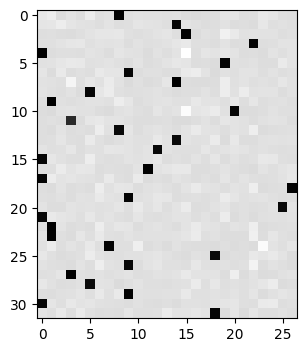

In [22]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray');

## 3. Exercise 3: batchNorm layer backward pass

* going to do the same thing for batchNorm we did for cross entropy loss in exercise 2. We're going to consider it as aglued single mathematical expression and back propogate through it in an efficient manner because we are going to derive a much simple formula for batch normalization
* in exercise 1 we broke down the batchNorm layer into pieces and and all the atomic operations inside and then we backpropogated through it one by one. Now, we just have a single sort of forward pass of a batchNorm and it's all glued together and we see that we get the same result as before. For backward pass we would also like to implement a single formula for backpropogating through this entire operation which is the batch normalization

### 3.1 forward pass

* in the forward pass previously, we took `hprebn`, the hidden states of the pre-batch normalization, and created `hpreact`, the hidden states just before the activation.
* in the batchNorm layer, `hprebn` is X and `hpreact` is Y. So, in the backward pass what we would like to do now is we have `dhpreact` and we would like to produce `dhprebn`, and we would like to do that in a very efficient manner.


In [23]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


### 3.2 backward pass

* calculate `dhprebn` given `dhpreact`
* for the purposes of this exercise we're going to ignore gamma and beta and their derivatives because they take on a very simple form in a very similar way as to what we did above.
* Follow the order of the numbers to backpropogate -> backpropogate into Xhat, then into var (sigma**2), then into mean (meu u) and then into X. Just like a topological sort in micrograd, we will go from right to left. We're doing the exact same thing except we're doing it with symbols and on a piece of paper.

  <img src = "https://raw.githubusercontent.com/Raahim58/Neural-networks/main/images/batchnorm.png" height = 400 width = 300>

  <img src = "https://raw.githubusercontent.com/Raahim58/Neural-networks/main/images/batchnorm%202.png" height = 400 width = 300>

* eq1: we have dL/dYi and we want dL/dXi for all the i's in these vectors. We have to be careful because these are vectors, there are many nodes here inside X, Xhat, and Y. However, mean (meu u) and var (sigma**2) are just individual scalars, single numbers. We have to imagine there are multiple nodes here or we will get out math wrong.

* eq2: there are many excess Xhats here and sigma^2 (var) is just a single individual number here. When we look at the expression for dL/dsigma^2, we have to actually consider all the possible paths that Xhat depends on sigma^2. Hence sigma^2 has a lot of fan outs, there's a lot of arrows coming out from sigma^2 into all the Xhats.
  * then there's a backpropogating signal from each Xhat into sigma^2 and that's why we need to sum over all those i's from i=1 to m, of the dL/dXihat which is the global gradient * XiHat/dSigma^2 (local gradient of operation 2). Then mathematically we solve it for eq 2 and we get a certain expression for dL/dsigma^2. We're going to be using this expression when we back propogate into mean (meu u) and then eventually into X.

* eq3: dL/dmu(u) continuing our backpropogation into mean (meu u). What is dL/dmu. We need to be careful again that mu influences Xhat and Xhat is actually lots of values. So for e.g, our mini batch size is 32, then Xhat is 32 numbers and 32 arrows going back to mu, and then mu going to sigma^2 is just a single arrow since sigma^2 is a scalar. In total there are 33 arrows emanating from `mu`, and then all of them have gradients coming into `mu` and they all need to be summed up.
  * We sum up all the gradients of dL/dXihat * dXihat/dmu (32 arrows) + dL/dsigma^2 * dsigma^2/dmu (1 arrow). We work out the expression mathematically
  * 1st term is simplified easily but for the 2nd term when we look at dsigma^2/dmu and then we simplify, at one point if we assume in a specialcase that mu is actually the average of Xi's as it is in this case, then we plug it in then gradient vanishes and becomes 0. This makes the entire second term cancel. In the special case where mu = average as it is in the case of batch normalization, the gradient will vanish and become 0. The whole term cancels and you get a straight forward expression for dL/dmu

* eq4: deriving dL/dXi which is ultimately what we're after.
  * Let's count how many numbers are there inside X. As i mentioned there are 32 numbers, 32 little Xi's. The number of arrows emanting from each Xi -> there's an arrow going to mu, and arrow going to sigma^2, and an arrow going to Xhat
  * scrutinizing the arrow going from each Xi to Xhat: each Xi hat is just a function of Xi and all the other scalars. So, Xihat only depends on Xi and none of the other X's. Therefore there are in this single arrow actually 32 arrows but those 32 arrows are going parallel without interfering, going between X and Xhat.
    * How many arrows are emanating from each Xi? there are 3 arrows: mu, sigma^2, and the associated Xhat. So in backpropogation we now need to apply the chain rule and we need to add those contributions:
      * we're chaining through mu, sigma^2 and Xhat. We already have the derivatives of all these 3 in the other 3 eq's. What we need now is the other 3 terms associated with the 3 expressions we got in the first 3 eq's
      * differentiating each of those expressions w.r.t Xi
      * gets a little bit more tricky when we add up it all together: we get a very big expression.
      * we need to be careful here working with dL/dXi for specifice i here, but when we are plugging in some of these terms like dL/dsigma^2, we need to not use i from the other eq's because the i is like running in the for loop for that specific equation which is different from the i in eq4. Hence, instead we use a j and make sure that the j is not the i we use in other eq's like eq2. The j is like a little local iterator over 32 terms. Some of these are hence j's and some are i's. Some terms cut out and you can just cancel them
      * when you simplify the expression you realize some of the terms that are coming out are just the Xihat's so you can simplify just by rewriting that.
  * the final expression use the stuff we have and it derives the thing we need so we have dL/dY for all the i's, and those are used plenty of times here. Also, i addition we are using Xihat's and Xjhat's, and they just come from the forward pass. Otherwise, this is just a simple expression and it gives us dL/dXi for all the i's which is what we're ultimately intersted in.
  * final backward pass implemented as a single expression. Getting this expression was not trivial and there's a lot going on pakced into this one formula and this is a whole exercise by itself. You have to consider the fact that the final expression derived is just for a single neuron and a batch of 32 examples. We actually have 64 neurons, so this layer has toe valuate the batchNorm backward pass for all those 64 neurons in parallel independely. This has to basically happen in all the column of inputs in the single backward pass code.
  * in addtion to that, we have a lot of sums in the final derived expression so we need to make sure that when we do those sums, we broadcast them correctly onto everything else here. Verify in the end with PyTorch itself in the end.

In [24]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [25]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape


(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

## 4. Putting it all together

* if you want to compare PyTorch backward pass with manual backprop then uncomment a few things as seen in code and run compare in the next code cell

In [50]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad(): # remove when comparing efficiency

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None

    # loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    # cross entropy loss
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd linear layer
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st linear layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.7562
  10000/ 200000: 2.1635
  20000/ 200000: 2.3736
  30000/ 200000: 2.4067
  40000/ 200000: 1.9977
  50000/ 200000: 2.3930
  60000/ 200000: 2.3773
  70000/ 200000: 2.0889
  80000/ 200000: 2.3315
  90000/ 200000: 2.1295
 100000/ 200000: 1.9589
 110000/ 200000: 2.3145
 120000/ 200000: 2.0229
 130000/ 200000: 2.4394
 140000/ 200000: 2.3821
 150000/ 200000: 2.0920
 160000/ 200000: 1.9606
 170000/ 200000: 1.8074
 180000/ 200000: 1.9932
 190000/ 200000: 1.9223


In [49]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

(27, 10) approximate, maxdiff=1.4901161193847656e-08
(30, 200) approximate, maxdiff=5.587935447692871e-09
(200,) approximate, maxdiff=3.4924596548080444e-09
(200, 27) approximate, maxdiff=1.4901161193847656e-08
(27,) approximate, maxdiff=8.381903171539307e-09
(1, 200) approximate, maxdiff=2.3283064365386963e-09
(1, 200) approximate, maxdiff=3.725290298461914e-09


compared results with one iteration (break result):

* (27, 10) approximate, maxdiff=1.4901161193847656e-08
* (30, 200) approximate, maxdiff=5.587935447692871e-09
* (200,) approximate, maxdiff=3.4924596548080444e-09
* (200, 27) approximate, maxdiff=1.4901161193847656e-08
* (27,) approximate, maxdiff=8.381903171539307e-09
* (1, 200) approximate, maxdiff=2.3283064365386963e-09
* (1, 200) approximate, maxdiff=3.725290298461914e-09

In [28]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [29]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0720419883728027
val 2.1110339164733887


got:
* train 2.0720419883728027
* val 2.1110339164733887

In [30]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
mad.
ryla.
reisa.
jendraeg.
adelynnelin.
shy.
jen.
eden.
estanaraelynn.
hoka.
cayshabergihimie.
trickennellennie.
cayus.
macder.
yarulyeha.
kayshayveyah.
hal.


## Summary

* manuall backproping gave us a diversity of layers to backpropogate through and it gives a comprehensive sense of how these backward passes are implemented and how they work
* you'd be able to derive them yourself but in practice you probably don't want to and just want to use the python autograd
* we have some intution of how grad flows backwards through the neural net starting from the loss and how they flow through all the variables and all the intermediate results and if you understood a good deal of it, consider yourself as the buff dog!
* next lecture will contains RNN's, LSTM, GRU. We will start to complexify the architecture and start to achieve better log likelihoods.

  <img src = "https://raw.githubusercontent.com/Raahim58/Neural-networks/main/images/summary.png" height = 500 width = 500>


## Extra curriculum



* Yes you should understand backprop: https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b
* BatchNorm paper: https://arxiv.org/abs/1502.03167
* Bessel’s Correction: http://math.oxford.emory.edu/site/mat...
